In [1]:
import numpy as np     
import pandas as pd
import matplotlib                          
import matplotlib.pyplot as plt
from pykat import finesse                 
from pykat.commands import *               
from pykat.optics.maps import * 
import pandas as pd
from pykat.parallel import parakat

%config InlineBackend.figure_format='svg'
%matplotlib inline
pykat.init_pykat_plotting(dpi=90)

                                              ..-
    PyKat 1.2.1           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



In [5]:
katHG00 = pykat.finesse.kat()
katHG00.verbose=False
katHG00.parse("""
l laser 1 0 0 n0
s s0 1 n0 nmod1

mod eom 60M 0.3 1 pm nmod1 nmod2
s s1 0 nmod2 n1

m1 ITM 0.014 3.75e-05 0 n1 n2
s sCav 3994.4692 n2 n3
m1 ETM 5e-06 3.75e-05 0 n3 n4

#higher order mode TEM33
#tem laser 0 0 0.0 0.0
#tem laser 3 3 1.0 0.0

#Gaussian model
cav cavity ITM n2 ETM n3
attr ITM Rc -2091.67
attr ETM Rc 2091.67
#Rc=2091.67 when clipping loss is 1ppm for HG00

pd1 pdh 60M 0 n1

set err pdh re
lock clock $err 1 1n
put* ETM phi $clock


maxtem 8

""")

In [2]:
#clipping loss of 1ppm
katHG33 = pykat.finesse.kat()
katHG33.verbose=False
katHG33.parse("""
l laser 1 0 0 n0
s s0 1 n0 nmod1

mod eom 60M 0.3 1 pm nmod1 nmod2
s s1 0 nmod2 n1

m1 ITM 0.014 3.75e-05 0 n1 n2
s sCav 3994.4692 n2 n3
m1 ETM 5e-06 3.75e-05 3.8 n3 n4

#higher order mode TEM33
tem laser 0 0 0.0 0.0
tem laser 3 3 1.0 0.0

#Gaussian model
cav cavity ITM n2 ETM n3
attr ITM Rc -2679.93
attr ETM Rc 2679.93
#Rc=2679.93 when clipping loss is 1ppm for HG33

pd1 pdh 60M 0 n1

set err pdh re
lock clock $err 1 1n
put* ETM phi $clock


maxtem 8

""")

In [3]:
#clipping loss of 1ppm
katLG22 = pykat.finesse.kat()
katLG22.verbose=False
katLG22.parse("""

l laser 1 0 0 n0
#gauss g1 laser n0 1m 0
maxtem 8

s s0 1 n0 nmod1
mod eom 60M 0.3 1 pm nmod1 nmod2
s s1 0 nmod2 n1
m1 ITM 0.014 3.75e-05 0 n1 n2
s sCav 3994.4692 n2 n3
m1 ETM 5e-06 3.75e-05 26.5 n3 n4

#higher order mode LG22
tem laser 0 0 0 0
tem laser 6 0 0.234375 0
tem laser 5 1 0.15625 -90
tem laser 4 2 0.015625 0
tem laser 3 3 0.1875 -90
tem laser 2 4 0.015625 180
tem laser 1 5 0.15625 -90
tem laser 0 6 0.234375 180

#Gaussian model
cav cavity ITM n2 ETM n3
attr ITM Rc -2789.58
attr ETM Rc 2789.58
#Rc=2789.58 when clipping loss is 1ppm for LG22

pd1 pdh 60M 0 n1
set err pdh re
lock clock $err 1 1n
put* ETM phi $clock

""")

In [10]:
HG00nomap = katHG00.deepcopy()  
HG00nomap.parse("""
        beam ccd 0 n3
        xaxis ccd x lin -10 10 200
        x2axis ccd y lin -10 10 200
        yaxis abs:deg
        """)
outHGnomap=HG00nomap.run()
beamHGnomap=outHGnomap["ccd"]


#reference power when applying zero map
HG00zeromap = katHG00.deepcopy()
HG00zeromap.parse("""
        map ETM Z2-2order0phasemap.txt
        pd Pcirc n3
        """)
HG00zeromap.noxaxis = True
outHGzeromap=HG00zeromap.run()
powerzeromap=outHGzeromap["Pcirc"]


pkLG=parakat()
for i in range(50):
    HG00beam = katHG00.deepcopy()
    HG00beam.parse(f"""
            map ETM randommaps/randommap{i}.txt
            beam ccd 0 n3
            xaxis ccd x lin -10 10 200
            x2axis ccd y lin -10 10 200
            yaxis abs:deg
            pd Pcirc n3
            """)
    pkLG.run(HG00beam)
outHGmap = pkLG.getResults()


# projecting the measureed beam profile to LG22 basis to get the purity
# and use the purity and measured power to get the loss
HGpurity=[]
HGloss=[]
for i in range(50):
    beamHGmap=outHGmap[i]['ccd']
    powermap=outHGmap[i]["Pcirc"]
    a=np.real(np.sum(np.conj(beamHGmap)*beamHGnomap)*np.sum(np.conj(beamHGnomap)*beamHGmap))
    b=np.sum(np.abs(beamHGmap)**2)
    c=np.sum(np.abs(beamHGnomap)**2)
    purity=np.sqrt(a/(b*c))
    
    loss=1-np.real(powermap*purity**2/powerzeromap)[0][0]
    HGpurity.append(purity)
    HGloss.append(loss)
    
pd.Series(HGpurity).to_pickle('pkl/randomHG00purity.pkl')
pd.Series(HGloss).to_pickle('pkl/randomHG00loss.pkl')

/opt/anaconda3/lib/python3.7/site-packages/ipyparallel/util.py:214: RuntimeWarning: IPython could not determine IPs for [Liu]: [Errno 8] nodename nor servname provided, or not known
  RuntimeWarning)
Parallel jobs: 100%|##########################################################|

In [13]:
HGpurity

[0.9999217355704028,
 0.9999654953362634,
 0.9999419891827401,
 0.9999155158485454,
 0.9999705171532222,
 0.999976313041127,
 0.9999448693995591,
 0.9999608107746075,
 0.9999538576927428,
 0.9999337079860913,
 0.9999173089465824,
 0.9999783912904778,
 0.9999588420172945,
 0.999975813062318,
 0.9999692778514409,
 0.9999325226865734,
 0.999954824536688,
 0.9999523237155239,
 0.9999645254536621,
 0.9999209986870223,
 0.999914886549359,
 0.9998995781264894,
 0.9999665463347985,
 0.9999172583193806,
 0.9998158434564733,
 0.9998487467583659,
 0.9998745840417197,
 0.9999713330829163,
 0.9999715503525402,
 0.9999798654279772,
 0.9999935531782956,
 0.9998162800595961,
 0.9999549024966223,
 0.9998549408336477,
 0.9998746942182657,
 0.999953837896104,
 0.9999829354949759,
 0.9999664055498294,
 0.9999686674556679,
 0.9999492591260584,
 0.999906266667593,
 0.99994135538495,
 0.9999783767841894,
 0.99996421032123,
 0.9999591084743744,
 0.999976155074911,
 0.9999658080136499,
 0.9999932473691425,
 0.

In [4]:
# to create a prefect LG22 basis to be projected into
LG22nomap = katLG22.deepcopy()  
LG22nomap.parse("""
        beam ccd 0 n3
        xaxis ccd x lin -7 7 200
        x2axis ccd y lin -7 7 200
        yaxis abs:deg
        """)
outLGnomap=LG22nomap.run()
beamLGnomap=outLGnomap["ccd"]


#reference power when applying zero map
LG22zeromap = katLG22.deepcopy()
LG22zeromap.parse("""
        map ETM Z2-2order0phasemap.txt
        pd Pcirc n3
        """)
LG22zeromap.noxaxis = True
outLGzeromap=LG22zeromap.run()
powerzeromap=outLGzeromap["Pcirc"]


pkLG=parakat()
for i in range(50):
    LG22beam = katLG22.deepcopy()
    LG22beam.parse(f"""
            map ETM randommaps/randommap{i}.txt
            beam ccd 0 n3
            xaxis ccd x lin -7 7 200
            x2axis ccd y lin -7 7 200
            yaxis abs:deg
            pd Pcirc n3
            """)
    pkLG.run(LG22beam)
outLGmap = pkLG.getResults()


# projecting the measureed beam profile to LG22 basis to get the purity
# and use the purity and measured power to get the loss
LGpurity=[]
LGloss=[]
for i in range(50):
    beamLGmap=outLGmap[i]['ccd']
    powermap=outLGmap[i]["Pcirc"]
    a=np.real(np.sum(np.conj(beamLGmap)*beamLGnomap)*np.sum(np.conj(beamLGnomap)*beamLGmap))
    b=np.sum(np.abs(beamLGmap)**2)
    c=np.sum(np.abs(beamLGnomap)**2)
    purity=np.sqrt(a/(b*c))
    
    loss=1-np.real(powermap*purity**2/powerzeromap)[0][0]
    LGpurity.append(purity)
    LGloss.append(loss)
    
pd.Series(LGpurity).to_pickle('pkl/randomLG22purity.pkl')
pd.Series(LGloss).to_pickle('pkl/randomLG22loss.pkl')

/opt/anaconda3/lib/python3.7/site-packages/pykat/finesse.py:2114: UserWarning: 'KatRun2D' does not have attribute called 'katPath'
  r.katPath = kat_exec
/opt/anaconda3/lib/python3.7/site-packages/pykat/finesse.py:2345: UserWarning: 'KatRun2D' does not have attribute called 'save_output'
  r.save_output = save_output
/opt/anaconda3/lib/python3.7/site-packages/pykat/finesse.py:2362: UserWarning: 'KatRun2D' does not have attribute called 'save_input'
  r.save_input = save_kat
/opt/anaconda3/lib/python3.7/site-packages/ipyparallel/util.py:214: RuntimeWarning: IPython could not determine IPs for [Liu]: [Errno 8] nodename nor servname provided, or not known
  RuntimeWarning)
Parallel jobs: 100%|##########################################################|

In [5]:
# to create a prefect HG33 basis to be projected into
HG33nomap = katHG33.deepcopy() 
HG33nomap.parse("""
        beam ccd 0 n3
        xaxis ccd x lin -7 7 200
        x2axis ccd y lin -7 7 200
        yaxis abs:deg
        """)
outHGnomap=HG33nomap.run()
beamHGnomap=outHGnomap["ccd"]


#reference power when applying zero map
HG33zeromap = katHG33.deepcopy()
HG33zeromap.parse("""
        map ETM Z2-2order0phasemap.txt
        pd Pcirc n3
        """)
HG33zeromap.noxaxis = True
outHGzeromap=HG33zeromap.run()
powerzeromap=outHGzeromap["Pcirc"]


pkHG=parakat()
for i in range(50):
    HG33beam = katHG33.deepcopy()
    HG33beam.parse(f"""
            map ETM randommaps/randommap{i}.txt
            beam ccd 0 n3
            xaxis ccd x lin -7 7 200
            x2axis ccd y lin -7 7 200
            yaxis abs:deg
            pd Pcirc n3
            """)
    pkHG.run(HG33beam)
outHGmap = pkHG.getResults()

HGpurity=[]
HGloss=[]
for i in range(50):
    beamHGmap=outHGmap[i]['ccd']
    powermap=outHGmap[i]["Pcirc"]
    a=np.real(np.sum(np.conj(beamHGmap)*beamHGnomap)*np.sum(np.conj(beamHGnomap)*beamHGmap))
    b=np.sum(np.abs(beamHGmap)**2)
    c=np.sum(np.abs(beamHGnomap)**2)
    purity=np.sqrt(a/(b*c))
    
    loss=1-np.real(powermap*purity**2/powerzeromap)[0][0]
    HGpurity.append(purity)
    HGloss.append(loss)
    
pd.Series(HGpurity).to_pickle('pkl/randomHG33purity.pkl')
pd.Series(HGloss).to_pickle('pkl/randomHG33loss.pkl')

Parallel jobs: 100%|##########################################################|

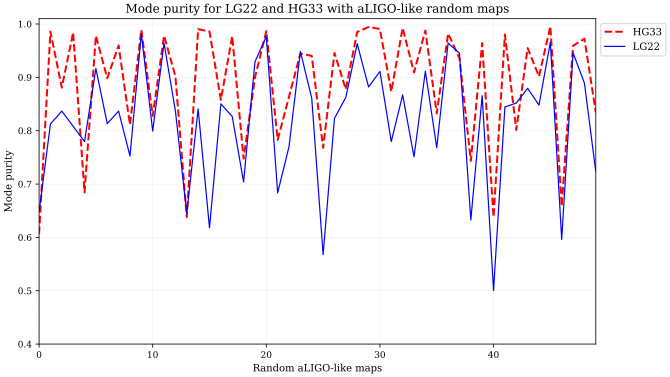

In [14]:
HG33purityZnm_array=pd.read_pickle('pkl/randomHG33purity.pkl').values
LG22purityZnm_array=pd.read_pickle('pkl/randomLG22purity.pkl').values
HG00purityZnm_array=pd.read_pickle('pkl/randomHG00purity.pkl').values

fig,ax =plt.subplots(figsize=(10,6))
ax.plot(HG33purityZnm_array,'r--',label='HG33', linewidth=2)
ax.plot(LG22purityZnm_array,'b',label='LG22')
#ax.plot(HG00purityZnm_array,'y',label='HG00')
# ax.axhline(y=np.mean(HG33purityZnm_array),color='y', label='HG33 average')
# ax.axhline(y=np.mean(LG22purityZnm_array), color='m', label='LG22 average')
ax.set_xlabel("Random aLIGO-like maps")
ax.set_ylabel("Mode purity")
ax.set_title("Mode purity for LG22 and HG33 with aLIGO-like random maps")
ax.set_ylim(0.4,1.01)
ax.legend(loc=2,bbox_to_anchor=(1,1))
plt.show()

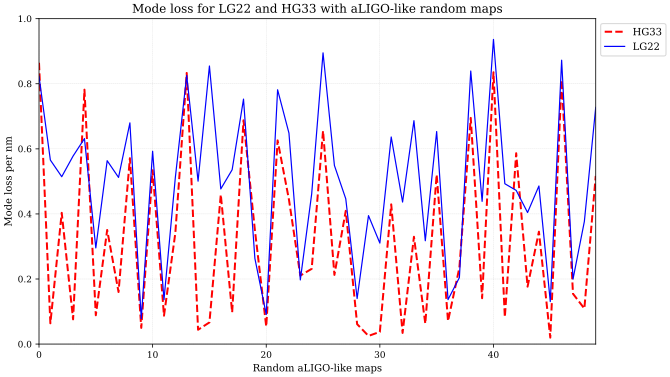

In [6]:
LG22lossZnm_array=pd.read_pickle('pkl/randomLG22loss.pkl').values
HG33lossZnm_array=pd.read_pickle('pkl/randomHG33loss.pkl').values

fig,ax =plt.subplots(figsize=(10,6))
ax.plot(HG33lossZnm_array,'r--',label='HG33',linewidth=2)
ax.plot(LG22lossZnm_array,'b',label='LG22')
# ax.axhline(y=np.mean(HG33lossZnm_array),color='y', label='HG33 average')
# ax.axhline(y=np.mean(LG22lossZnm_array), color='m', label='LG22 average')
ax.set_xlabel("Random aLIGO-like maps")
ax.set_ylabel("Mode loss per nm")
ax.set_title("Mode loss for LG22 and HG33 with aLIGO-like random maps")
ax.set_ylim(0,1)
ax.legend(loc=2,bbox_to_anchor=(1,1))
plt.show()